In [1]:
using LinearAlgebra, Random, Distributions, DynamicalSystems,  Plots
import Distributions: Uniform 

In [2]:
function kronecker_δ(i,j)
    if i == j
        return 1
    else
        return 0
    end
end

kronecker_δ(0,2)

0

In [3]:
function make_weight_matrix(g, N)
    dist = Normal(0, g^2/N)
    J = rand(dist, (N,N))
    return J - Diagonal(J)
end

make_weight_matrix(0.9, 4)

4×4 Array{Float64,2}:
  0.0        0.062359   0.0207278   0.173779
  0.11012    0.0        0.081559    0.183699
 -0.245779  -0.0227284  0.0        -0.12678
 -0.215375  -0.395378   0.192414    0.0

In [4]:
function instantaneous_jacobian(J,h)
    N = size(J)[1]
    output = zeros(N,N)
    for i = 1:N
        for j = 1:N
            output[i,j] = -kronecker_δ(i,j) + J[i,j]*sech(h[j])^2
        end
    end
    return output
end

J = make_weight_matrix(1,5)
h = rand(5)
instantaneous_jacobian(J,h)


5×5 Array{Float64,2}:
 -1.0        -0.0794417  -0.118437   -0.102018   -0.252004
 -0.0615077  -1.0         0.0636773   0.234295   -0.11053
 -0.0657211   0.207729   -1.0         0.0228024   0.0976858
 -0.10803     0.124171   -0.223248   -1.0        -0.140891
  0.244574    0.0446457  -0.411073    0.100519   -1.0

In [5]:
x=7
2x

14

In [6]:
function longterm_jacobian(series, J)
    # input sampled trajectory
    t = size(series)[1]
    N = size(series)[2]
    T_t = instantaneous_jacobian(J, series[1,:])
    for i = 2:t
        T_t = T_t*instantaneous_jacobian(J, series[i,:])
    end
    return T_t
end


longterm_jacobian (generic function with 1 method)

In [7]:
@inline @inbounds function engelken_tanh_model(u, p, t)
    J = p[1];
    
    # We need to first make W
    
    N = size(J)[1]
    
    du = []
    for i = 1:N
        argument = -u[i]
        for j = 1:N
            argument = argument + J[i,j]*tanh(u[j])
        end
        du = [du; argument]
    end

    
    return SVector{N}(du)
end

engelken_tanh_model (generic function with 1 method)

In [8]:
N = 100
g = 10
Random.seed!(40);
J = make_weight_matrix(g, N)
x0 = rand(Uniform(-1,1),N)

ds = ContinuousDynamicalSystem(engelken_tanh_model, x0, [J])

100-dimensional continuous dynamical system
 state:       [-0.304762, 0.643961, -0.352773, …, 0.559021, 0.852064]
 rule f:      engelken_tanh_model
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [[0.0 0.130498 … 0.92399 0.376207; -0.698378 0.0 … 0.430656 0.157473; … ; -1.08712 -0.427707 … 0.0 0.25013; 0.0578533 -1.13861 … -0.167222 0.0]]


In [9]:
tr = trajectory(ds, 1000);

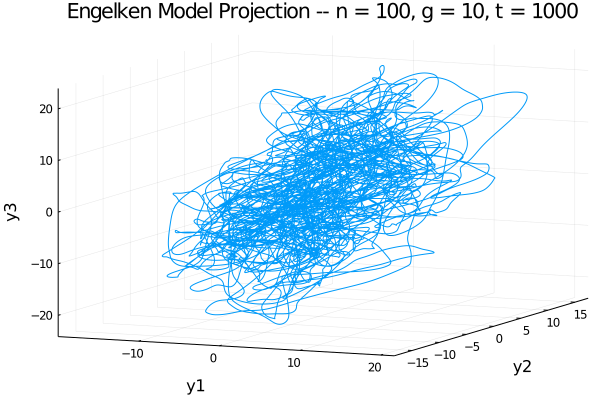

In [10]:
plot(tr[:, 1], tr[:, 2],tr[:, 3], 
    leg=false,
    title="Engelken Model Projection -- n = 100, g = 10, t = 1000",
    xlabel="y1",
    ylabel="y2",
    zlabel="y3")

In [11]:
tr = tr[1:10001,:];

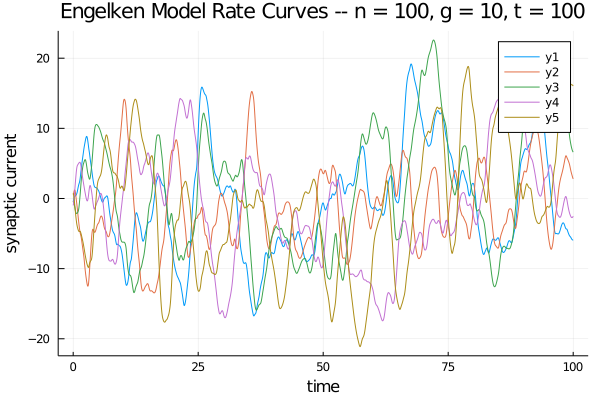

In [12]:
t = [0:0.01:100;]
plot(t,tr[:,1],
    title="Engelken Model Rate Curves -- n = 100, g = 10, t = 100",
    xlabel = "time",
    ylabel = "synaptic current")
plot!(t,tr[:,2])
plot!(t,tr[:,3])
plot!(t,tr[:,4])
plot!(t,tr[:,5])

In [13]:
stability_matrix = instantaneous_jacobian(J,tr[end,:]);
eig = eigvals(stability_matrix);
N = size(J)[1]
real_part = zeros(1,N)
imaginary_part = zeros(1,N)

for i = 1:N
    real_part[i] = real(eig[i]) 
    imaginary_part[i] = imag(eig[i])
end

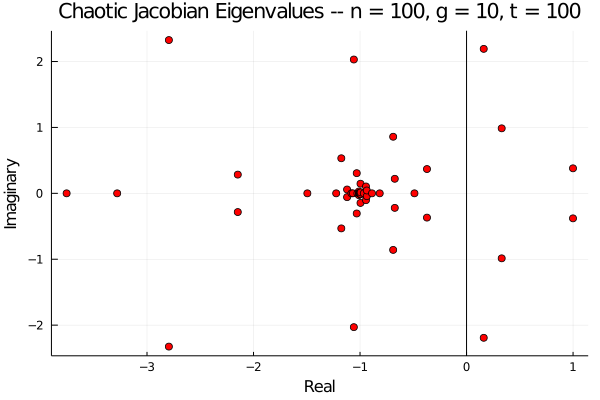

In [14]:
plot(real_part, imaginary_part,
    seriestype = :scatter, 
    title = "Chaotic Jacobian Eigenvalues -- n = 100, g = 10, t = 100",
    legend = false, 
    color = "red",
    xlabel = "Real",
    ylabel = "Imaginary")
plot!([0], 
    seriestype="vline",
    color = "black")

vline!(0)

In [15]:
N = 100
g = 5
Random.seed!(2);
J = make_weight_matrix(g, N)
x0 = rand(Uniform(-1,1),N)

ds = ContinuousDynamicalSystem(engelken_tanh_model, x0, [J])

100-dimensional continuous dynamical system
 state:       [0.257692, -0.59448, 0.274657, 0.917221, …, -0.417618, 0.61601]
 rule f:      engelken_tanh_model
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [[0.0 -0.186127 … -0.143876 0.0705745; -0.139483 0.0 … -0.197779 -0.0901436; … ; -0.234165 -0.278551 … 0.0 -0.370125; -0.00829295 -0.108134 … -0.0943632 0.0]]


In [16]:
tr = trajectory(ds, 1000);

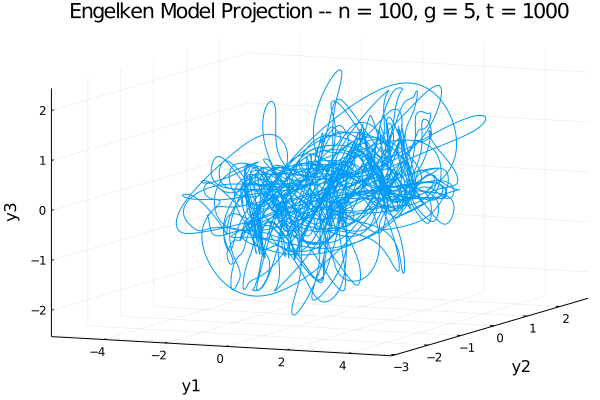

In [17]:
plot(tr[:, 1], tr[:, 2],tr[:, 3], leg=false, 
    title="Engelken Model Projection -- n = 100, g = 5, t = 1000",
    xlabel="y1",
    ylabel="y2",
    zlabel="y3"
)

In [18]:
tr = tr[1:10001,:]

100-dimensional Dataset{Float64} with 10001 points
 0.257692  -0.59448   0.274657   0.917221  …  -0.535941  -0.417618  0.61601
 0.27132   -0.60881   0.277697   0.904035     -0.530518  -0.419945  0.615657
 0.28427   -0.623073  0.280631   0.891093     -0.525477  -0.421965  0.615115
 0.29654   -0.63725   0.28345    0.878396     -0.520813  -0.423688  0.614377
 0.30813   -0.651323  0.286145   0.865943     -0.516524  -0.425118  0.613435
 0.319039  -0.665276  0.288707   0.853734  …  -0.512605  -0.426266  0.612283
 0.329268  -0.67909   0.291128   0.841771     -0.509054  -0.427137  0.610913
 0.338818  -0.692752  0.293402   0.830052     -0.505865  -0.42774   0.609319
 0.347691  -0.706244  0.295521   0.818578     -0.503036  -0.428083  0.607494
 0.355888  -0.719553  0.29748    0.807348     -0.500561  -0.428175  0.605433
 0.363413  -0.732664  0.299275   0.796361  …  -0.498436  -0.428022  0.603129
 0.370268  -0.745565  0.300901   0.785617     -0.496658  -0.427634  0.600578
 0.376459  -0.758242  0.30

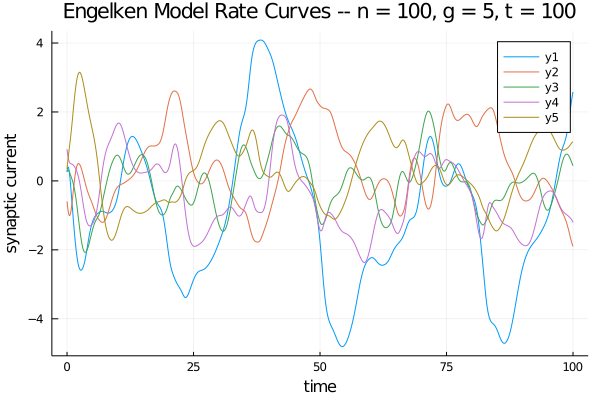

In [19]:
t = [0:0.01:100;]
plot(t,tr[:,1],
    title="Engelken Model Rate Curves -- n = 100, g = 5, t = 100",
    xlabel = "time",
    ylabel = "synaptic current")
plot!(t,tr[:,2])
plot!(t,tr[:,3])
plot!(t,tr[:,4])
plot!(t,tr[:,5])

In [20]:
stability_matrix = instantaneous_jacobian(J,tr[end,:]);
eig = eigvals(stability_matrix);
N = size(J)[1]
real_part = zeros(1,N)
imaginary_part = zeros(1,N)

for i = 1:N
    real_part[i] = real(eig[i]) 
    imaginary_part[i] = imag(eig[i])
end

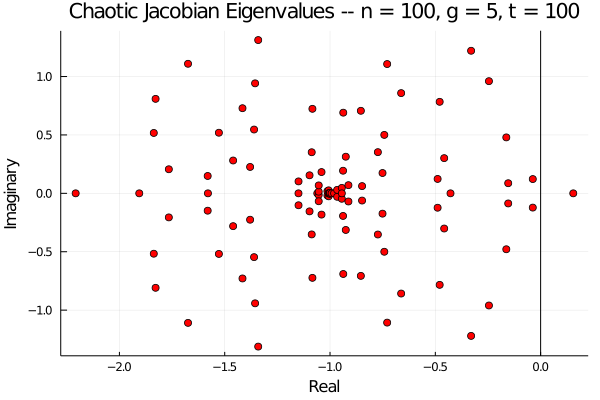

In [21]:
plot(real_part, imaginary_part,
    seriestype = :scatter, 
    title = "Chaotic Jacobian Eigenvalues -- n = 100, g = 5, t = 100",
    legend = false, 
    color = "red",
    xlabel = "Real",
    ylabel = "Imaginary")
plot!([0], 
    seriestype="vline",
    color = "black")

vline!(0)

In [22]:
N = 100
g = 3
Random.seed!(42);
J = make_weight_matrix(g, N)
x0 = rand(Uniform(-1,1),N)

ds = ContinuousDynamicalSystem(engelken_tanh_model, x0, [J])

100-dimensional continuous dynamical system
 state:       [0.965028, 0.910654, 0.138508, …, -0.910611, 0.627238]
 rule f:      engelken_tanh_model
 in-place?    false
 jacobian:    ForwardDiff
 parameters:  [[0.0 -0.0399945 … -0.0918377 -0.118036; 0.061836 0.0 … 0.0477807 0.0852774; … ; 0.025614 -0.0171632 … 0.0 0.209886; -0.121533 0.0401624 … 0.0758892 0.0]]


In [23]:
tr = trajectory(ds, 100);

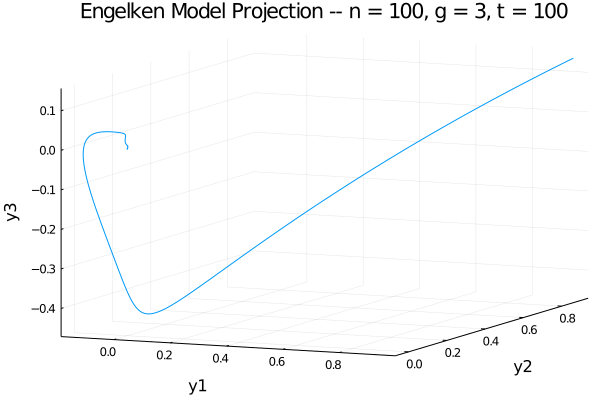

In [24]:
plot(tr[:, 1], tr[:, 2],tr[:, 3], leg=false, 
    title="Engelken Model Projection -- n = 100, g = 3, t = 100",
    xlabel="y1",
    ylabel="y2",
    zlabel="y3"
)

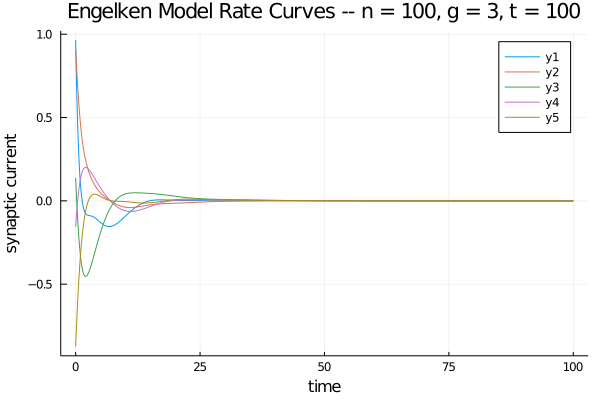

In [25]:
t = [0:0.01:100;]
plot(t,tr[:,1],
    title="Engelken Model Rate Curves -- n = 100, g = 3, t = 100",
    xlabel = "time",
    ylabel = "synaptic current")
plot!(t,tr[:,2])
plot!(t,tr[:,3])
plot!(t,tr[:,4])
plot!(t,tr[:,5])

In [26]:
stability_matrix = instantaneous_jacobian(J,tr[end,:]);
eig = eigvals(stability_matrix);
N = size(J)[1]
real_part = zeros(1,N)
imaginary_part = zeros(1,N)

for i = 1:N
    real_part[i] = real(eig[i]) 
    imaginary_part[i] = imag(eig[i])
end

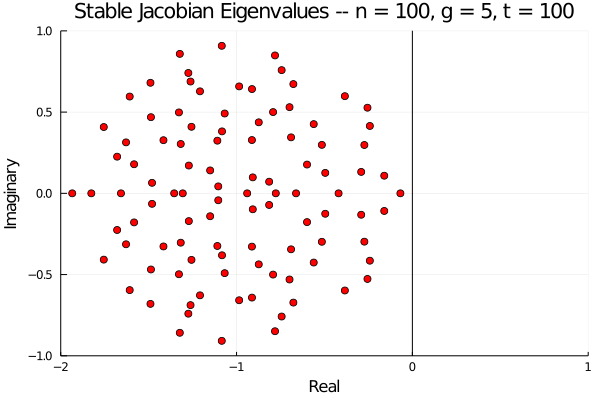

In [30]:
plot(real_part, imaginary_part,
    seriestype = :scatter, 
    title = "Stable Jacobian Eigenvalues -- n = 100, g = 5, t = 100",
    legend = false, 
    color = "red",
    xlabel = "Real",
    ylabel = "Imaginary")
plot!([0], 
    seriestype="vline",
    color = "black")
ylims!((-1,1))
xlims!((-2,1))
vline!(0)